<a href="https://colab.research.google.com/github/blessedgem/CommunityPolicing/blob/master/tpra_trust_simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# --- Notebook setup cell ---
# 1) Install the required packages in the notebook environment (quiet mode):
#    - numpy: numerical arrays + random number generation
#    - pandas: tabular data handling (DataFrames)
#    - matplotlib: plotting/visualization
#    - tqdm: progress bars for loops

!pip -q install numpy pandas matplotlib tqdm

# 2) Import the libraries so we can use them in later cells:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# 3) Reproducibility: create a seeded random number generator.
#    Setting a fixed seed means "random" draws will be the same each time
#    you rerun the notebook (as long as you draw numbers in the same order),
#    making simulations/debugging/comparisons repeatable.
# Reproducibility
GLOBAL_SEED = 42
rng = np.random.default_rng(GLOBAL_SEED)


In [3]:
# CONFIG is a single “settings” dictionary that controls the whole simulation.
# Think of it as the knobs you can turn to change population size, trust behavior,
# voting rules, and how many Monte Carlo trials you run.

CONFIG = {
    # -------------------------
    # Population / simulation size
    # -------------------------
    "num_vendors": 30,      # how many vendors are being assessed in the simulation
    "num_assessors": 12,    # how many assessors exist to review/vote
    "num_controls": 25,     # how many controls (e.g., NIST controls) each vendor is evaluated on
    "num_ranks": 5,         # number of criticality levels for controls (ranks 1..R)
    "cycles": 8,            # how many assessment cycles occur over time (e.g., repeated audits)

    # -------------------------
    # Trust weight parameters (alpha, beta, gamma, delta)
    # These weights will likely be used in a trust score formula such as:
    #   Trust = alpha*sustainment + beta*participation + gamma*lifetime + delta*something_else
    # The key idea: each term contributes a fraction of the final trust score.
    # -------------------------
    "alpha": 0.35,          # weight for "sustainment" (how well performance is maintained over cycles)
    "beta": 0.25,           # weight for "participation" (how actively an assessor participates)
    "gamma": 0.15,          # weight for "lifetime" (experience/tenure/history length)
    # "delta" is intentionally not set here; it will be computed so weights sum to 1.

    # -------------------------
    # Sustainment sensitivity
    # Controls how strongly trust reacts to improvement/regression over time.
    # Smaller kappa => bigger response (more sensitive).
    # Larger kappa => smoother/less reactive trust changes.
    # -------------------------
    "kappa": 0.15,

    # -------------------------
    # Voting parameters
    # In a weighted voting scheme, each assessor's vote is multiplied by their trust weight,
    # and the weighted sum/average is compared to a threshold.
    # -------------------------
    "eta": 0.5,             # pass threshold for weighted vote (e.g., >= 0.5 means "pass")
    "epsilon": 1e-9,        # tiny constant to avoid divide-by-zero or log(0) in calculations

    # -------------------------
    # Monte Carlo settings
    # Monte Carlo = repeat the simulation multiple times with randomness to estimate averages/variance.
    # -------------------------
    "runs": 50,             # number of independent simulation runs (higher => more stable averages, slower runtime)
}

# Compute delta so that alpha + beta + gamma + delta = 1 exactly.
# This ensures your trust weights form a proper convex combination (a weighted average).
CONFIG["delta"] = 1 - CONFIG["alpha"] - CONFIG["beta"] - CONFIG["gamma"]

# In a notebook, putting "CONFIG" on the last line displays the dictionary output.
CONFIG


{'num_vendors': 30,
 'num_assessors': 12,
 'num_controls': 25,
 'num_ranks': 5,
 'cycles': 8,
 'alpha': 0.35,
 'beta': 0.25,
 'gamma': 0.15,
 'kappa': 0.15,
 'eta': 0.5,
 'epsilon': 1e-09,
 'runs': 50,
 'delta': 0.25}

In [4]:
def clip01(x):
    """
    Clamp (aka "clip") a value into the range [0, 1].

    Why this is useful:
    - Many simulation variables represent probabilities, scores, or weights that must stay between 0 and 1.
    - Any value < 0 becomes 0, any value > 1 becomes 1, and values in between stay unchanged.

    Steps:
    1) Convert x to a float (so inputs like ints, numpy scalars, strings like "0.7" become numeric).
    2) min(1.0, ...) ensures the value is not above 1.0.
    3) max(0.0, ...) ensures the result is not below 0.0.
    """
    return max(0.0, min(1.0, float(x)))


def sustainment_from_delta(delta, kappa):
    """
    Convert a change value (delta) into a sustainment score S in [0, 1].

    Intended meaning:
    - delta (Δ) represents improvement/regression in performance between cycles.
        * Δ > 0  => improvement
        * Δ = 0  => no change
        * Δ < 0  => regression
    - kappa (κ) controls sensitivity:
        * smaller κ => the same Δ causes a larger change in S (more reactive)
        * larger κ  => S changes more slowly (more stable)

    Formula (before clipping):
        S = 0.5 + Δ / (2κ)

    Interpretation:
    - Baseline is 0.5 when Δ = 0.
    - If Δ = +κ, then S = 0.5 + (κ / (2κ)) = 1.0  (max)
    - If Δ = -κ, then S = 0.5 - (κ / (2κ)) = 0.0  (min)
    - Values beyond ±κ would push S beyond [0,1], so we clip them.

    The clip01(...) call enforces the final score stays within [0, 1].
    """
    return clip01(0.5 + (delta / (2 * kappa)))


In [5]:
def make_event(cycle, actor_type, actor_id, event_type,
               control_id=None, rank=None, is_bad=False, bad_weight=0.0):
    """
    Create a standardized "event record" (a Python dict) for the simulation.

    Purpose:
    - Simulations often generate lots of actions over time (e.g., a vendor submits evidence,
      an assessor votes, someone misses participation, etc.).
    - This function ensures every event is stored in the same structured format, which makes it
      easy to:
        * log events consistently,
        * convert logs into a pandas DataFrame,
        * compute statistics per cycle/actor/control,
        * debug or visualize what happened.

    Parameters:
    - cycle: (int) which assessment cycle/time-step this event belongs to
    - actor_type: (str) who caused the event, typically "vendor" or "assessor"
    - actor_id: (int/str) unique ID of the actor (e.g., vendor #7, assessor #3)
    - event_type: (str) what happened (e.g., "submit_evidence", "vote", "no_show", etc.)
    - control_id: (optional) which control this event relates to (if applicable)
    - rank: (optional) criticality rank of the control (1..R), if used by your model
    - is_bad: (bool) whether this event is considered “bad” behavior/outcome
              (e.g., malicious action, non-compliance, missed duty)
    - bad_weight: (float) severity/impact score for the bad event
                  (e.g., how harmful it is; can be used to penalize trust)

    Returns:
    - A dictionary representing the event, with consistent keys for later processing.
    """
    return {
        "cycle": cycle,               # time-step of the simulation
        "actor_type": actor_type,     # "vendor" or "assessor"
        "actor_id": actor_id,         # identifier for the specific actor
        "event_type": event_type,     # label describing what happened
        "control_id": control_id,     # which control is involved (or None)
        "rank": rank,                 # control rank/criticality (or None)
        "is_bad": bool(is_bad),       # force True/False (even if given 0/1 or np.bool_)
        "bad_weight": float(bad_weight), # force numeric float for scoring/math
    }


In [6]:
def compute_counters(events, num_vendors, num_assessors, num_ranks, eps=1e-9):
    """
    Aggregate raw simulation "events" into per-entity counters that can later be used
    to compute trust, participation, penalties, etc.

    Inputs:
    - events: list of event dictionaries (from make_event(...)), each describing one action
    - num_vendors: total number of vendors in the simulation
    - num_assessors: total number of assessors in the simulation
    - num_ranks: number of criticality ranks (1..R). (Note: currently not used directly here,
      but kept in the signature in case you want to normalize or weight by rank later.)
    - eps: small constant (currently unused here) that is often included to prevent divide-by-zero
      in later computations.

    Outputs:
    - counters: a nested dict of numpy arrays, containing per-vendor and per-assessor totals:
        * N: number of events (how many actions the entity took)
        * B: accumulated "badness" penalty (sum of bad_weight for bad events)
        * Pts: participation points (here: vendors earn points for certain positive evidence actions)
        * lifetime: number of cycles the entity participated in (incremented once per cycle if seen)

    Important behavior:
    - lifetime is NOT the number of events. It is "did they show up this cycle?"
      So lifetime increases by 1 at most per cycle per entity.
    """

    # -------------------------
    # 1) Initialize counters
    # -------------------------
    counters = {
        "vendor": {
            "N": np.zeros(num_vendors),        # N[v] = total number of vendor v events
            "B": np.zeros(num_vendors),        # B[v] = total badness penalty for vendor v
            "Pts": np.zeros(num_vendors),      # Pts[v] = participation points for vendor v
            "lifetime": np.zeros(num_vendors), # lifetime[v] = number of cycles vendor v participated in
        },
        "assessor": {
            "N": np.zeros(num_assessors),        # N[a] = total number of assessor a events
            "B": np.zeros(num_assessors),        # B[a] = total badness penalty for assessor a
            "Pts": np.zeros(num_assessors),      # optional: currently not used/earned for assessors here
            "lifetime": np.zeros(num_assessors), # lifetime[a] = number of cycles assessor a participated in
        }
    }

    # -------------------------
    # 2) Track who participated in this cycle (for lifetime)
    # -------------------------
    # We use sets so each actor is counted once per cycle even if they produced many events.
    seen_vendor = set()
    seen_assessor = set()

    # -------------------------
    # 3) Iterate through events and accumulate counters
    # -------------------------
    for e in events:
        t = e["actor_type"]   # "vendor" or "assessor"
        i = e["actor_id"]     # actor index (must be in range: vendors [0..num_vendors-1], assessors [0..num_assessors-1])

        # Count every event as participation/activity volume
        counters[t]["N"][i] += 1

        # If the event is marked bad, add its severity into the badness total
        if e["is_bad"]:
            counters[t]["B"][i] += e["bad_weight"]

        # Participation points: only for vendors and only for certain "good" event types
        # (simple initial scoring rule; you can expand this later)
        if t == "vendor" and e["event_type"] in ["EvidenceAccepted", "RemediationAccepted"]:
            r = int(e["rank"])                      # control rank (e.g., 1..R)
            counters["vendor"]["Pts"][i] += r       # higher-rank actions earn more points

        # Mark the actor as having participated this cycle (for lifetime increment later)
        if t == "vendor":
            seen_vendor.add(i)
        else:
            seen_assessor.add(i)

    # -------------------------
    # 4) Lifetime: increment once per cycle for each actor that appeared at least once
    # -------------------------
    for i in seen_vendor:
        counters["vendor"]["lifetime"][i] += 1
    for i in seen_assessor:
        counters["assessor"]["lifetime"][i] += 1

    # Return the aggregated counters for downstream trust/voting calculations
    return counters


In [7]:
def compute_delta_maturity(prev_pass, curr_pass):
    """
    Compute a single "maturity change" value (delta) between two cycles
    based on control pass/fail outcomes.

    Inputs:
    - prev_pass: array-like of shape [num_controls], containing 0/1 values
                 0 = control failed in previous cycle
                 1 = control passed in previous cycle
    - curr_pass: array-like of shape [num_controls], containing 0/1 values
                 0 = control failed in current cycle
                 1 = control passed in current cycle

    What it returns:
    - delta_maturity: a normalized score roughly in [-1, +1]
        * positive => net improvement
        * near 0   => mostly sustained / little net change
        * negative => net regression
    - improvement_count: number of controls that went from fail -> pass (0 -> 1)
    - sustain_count: number of controls that stayed pass -> pass (1 -> 1)
    - regression_count: number of controls that went from pass -> fail (1 -> 0)

    Intuition:
    - Improvements and regressions are treated as the strongest signals.
    - Sustainment is positive but weaker than improvements.
    - The final delta is normalized so it is comparable across different #controls.
    """

    # Convert inputs into numpy arrays so element-wise comparisons work reliably
    prev_pass = np.asarray(prev_pass)
    curr_pass = np.asarray(curr_pass)

    # Count improvements: previously failed (0) and now passed (1)
    improved = np.sum((prev_pass == 0) & (curr_pass == 1))

    # Count sustainment: previously passed (1) and still passed (1)
    sustained = np.sum((prev_pass == 1) & (curr_pass == 1))

    # Count regressions: previously passed (1) and now failed (0)
    regressed = np.sum((prev_pass == 1) & (curr_pass == 0))

    # Build a simple weighted score:
    # - Improvement is strongly positive (+2 each)
    # - Sustainment is mildly positive (+1 each)
    # - Regression is strongly negative (-2 each)
    # This makes regressions "hurt" as much as improvements "help".
    score = (2 * improved + 1 * sustained - 2 * regressed)

    # Normalize the score so delta isn't automatically larger just because you have more controls.
    # max_score here is a rough upper bound (if everything improved or sustained strongly).
    # The +1e-9 prevents divide-by-zero if max_score is 0 (extreme edge case).
    max_score = 2 * len(curr_pass)
    delta = score / (max_score + 1e-9)

    # Return delta as a Python float, and the counts as Python ints
    return float(delta), int(improved), int(sustained), int(regressed)


In [8]:
# --- Step 7A: Controls (NIST 800-53 Rev 5) - Access Control (AC) category ---
# ============================================================
# STEP 7A: Define which controls we are assessing (scope)
# We choose NIST 800-53 Rev 5 "Access Control (AC)" because TPRA
# evidence is realistic and common (IAM, MFA, access reviews, etc.)
#
# Each control also has a "rank" (1..5) representing criticality.
# We use rank later for Participation points (higher rank = more points).
# ============================================================

CONTROLS = [
    {"id": "AC-2", "name": "Account Management",        "rank": 5},
    {"id": "AC-3", "name": "Access Enforcement",        "rank": 5},
    {"id": "AC-6", "name": "Least Privilege",           "rank": 5},
    {"id": "AC-7", "name": "Unsuccessful Login Attempts","rank": 4},
    {"id": "AC-5", "name": "Separation of Duties",      "rank": 4},
    {"id": "AC-11","name": "Session Lock",              "rank": 3},
    {"id": "AC-12","name": "Session Termination",       "rank": 3},
    {"id": "AC-8", "name": "System Use Notification",   "rank": 2},
]

# Convenience helpers: list of IDs and a map from control_id -> rank
CONTROL_IDS = [c["id"] for c in CONTROLS]
CONTROL_RANK = {c["id"]: c["rank"] for c in CONTROLS}

len(CONTROLS), CONTROLS[:2]


(8,
 [{'id': 'AC-2', 'name': 'Account Management', 'rank': 5},
  {'id': 'AC-3', 'name': 'Access Enforcement', 'rank': 5}])

Rows in category: 4


,question_id,rank,question,expected_evidence,framework_refs
0,ACC-01,4,How does the vendor manage access control for ...,"[IAM policy, RBAC documentation, onboarding, o...",{'HIPAA': 'Technical Safeguards: Access Contro...
1,ACC-02,5,What authentication and authorization methods ...,"[MFA policy, architecture diagrams, enforcemen...",{'HIPAA': 'Technical Safeguards: Access Contro...
2,ACC-03,2,What identity and access management (IAM) solu...,"[IAM system overview, architecture documentation]",{'HIPAA': 'Technical Safeguards: Access Contro...
3,ACC-04,5,How are user credentials and permissions manag...,"[User management policies, procedures, audit l...",{'HIPAA': 'Technical Safeguards: Access Contro...


In [12]:
# ============================================================
# STEP 7B: Assign "behavior types" to vendors.
# This represents real TPRA populations:
# - Most vendors are honest (trying to comply).
# - Some are noisy (operational mistakes, delays, inconsistent evidence).
# - A small group are adversarial (try to game the assessment).
#
# Adversary strategies:
# - breakout_fraud: looks good at onboarding then regresses later
# - stale_evidence: reuses old screenshots/logs outside the cycle window
# - scope_gaming: tries to exclude critical systems from assessment scope
# ============================================================

def assign_vendor_types(num_vendors, rng,
                        p_honest=0.70,
                        p_noisy=0.20,
                        p_adv=0.10):
    """
    Returns a list vendor_types[v] in:
      {"honest", "noisy", "breakout_fraud", "stale_evidence", "scope_gaming"}
    """
    assert abs(p_honest + p_noisy + p_adv - 1.0) < 1e-9

    types = []
    for v in range(num_vendors):
        r = rng.random()

        # Majority: honest
        if r < p_honest:
            types.append("honest")

        # Next: noisy/weak operations
        elif r < p_honest + p_noisy:
            types.append("noisy")

        # Small fraction: adversarial
        else:
            adv_kind = rng.choice(["breakout_fraud", "stale_evidence", "scope_gaming"])
            types.append(adv_kind)

    return types

vendor_types = assign_vendor_types(CONFIG["num_vendors"], rng)

# Quick sanity check: count how many vendors of each type
print(pd.Series(vendor_types).value_counts())


honest            21
noisy              6
breakout_fraud     2
scope_gaming       1
Name: count, dtype: int64


In [13]:
# ============================================================
# STEP 7C: Ground truth control implementation state (behind the scenes)
#
# For each vendor v and control c:
#   state[v][c] = 1 means the control is implemented correctly
#   state[v][c] = 0 means the control is not implemented / failing
#
# This "ground truth" is what an ideal auditor would see.
# Our simulated assessors will only see evidence and votes (later).
#
# We also define how this ground truth evolves cycle-to-cycle:
# - honest: gradually improves, rare regressions
# - noisy: fluctuates more (mistakes, inconsistent operations)
# - breakout_fraud: looks good early, then regresses after cycle 1
# - stale_evidence / scope_gaming: moderate implementation, slower movement
# ============================================================

def init_vendor_control_state(num_vendors, controls, vendor_types, rng):
    """
    Initialize each vendor's baseline control quality.
    Returns: dict state[v][control_id] -> 0/1
    """
    state = {v: {} for v in range(num_vendors)}

    for v in range(num_vendors):
        t = vendor_types[v]

        # Baseline "probability control is implemented"
        # (These are realistic-ish starting priors; we can tune later.)
        if t in ["honest", "breakout_fraud"]:
            base_prob = 0.85
        elif t == "noisy":
            base_prob = 0.65
        else:
            # stale_evidence or scope_gaming
            base_prob = 0.75

        # Assign 0/1 per control
        for c in controls:
            cid = c["id"]
            state[v][cid] = 1 if rng.random() < base_prob else 0

    return state


def evolve_vendor_control_state(prev_state, controls, vendor_types, cycle, rng):
    """
    Update ground truth state for next cycle.
    Returns: new_state[v][control_id] -> 0/1
    """
    new_state = {v: dict(prev_state[v]) for v in prev_state.keys()}

    for v in prev_state.keys():
        t = vendor_types[v]

        for c in controls:
            cid = c["id"]

            # HONEST: improve gradually, rare regressions
            if t == "honest":
                if new_state[v][cid] == 0 and rng.random() < 0.12:  # fix gaps
                    new_state[v][cid] = 1
                if new_state[v][cid] == 1 and rng.random() < 0.03:  # small drift/regression
                    new_state[v][cid] = 0

            # NOISY: more random flips (ops instability)
            elif t == "noisy":
                if rng.random() < 0.10:
                    new_state[v][cid] = 1 - new_state[v][cid]

            # BREAKOUT FRAUD: good at cycle 1, then degrades after
            elif t == "breakout_fraud":
                if cycle >= 2 and new_state[v][cid] == 1 and rng.random() < 0.12:
                    new_state[v][cid] = 0
                if cycle >= 2 and new_state[v][cid] == 0 and rng.random() < 0.03:
                    new_state[v][cid] = 1

            # STALE EVIDENCE / SCOPE GAMING: moderate, slower movement
            else:
                if new_state[v][cid] == 0 and rng.random() < 0.05:
                    new_state[v][cid] = 1
                if new_state[v][cid] == 1 and rng.random() < 0.05:
                    new_state[v][cid] = 0

    return new_state


# Initialize ground truth state at Cycle 1
vendor_state = init_vendor_control_state(CONFIG["num_vendors"], CONTROLS, vendor_types, rng)

print("Initialized vendor_state for cycle 1.")
print("Example vendor 0 type:", vendor_types[0])
print("Vendor 0 sample control states:", {k: vendor_state[0][k] for k in CONTROL_IDS[:4]})


Initialized vendor_state for cycle 1.
Example vendor 0 type: honest
Vendor 0 sample control states: {'AC-2': 0, 'AC-3': 1, 'AC-6': 1, 'AC-7': 1}


In [14]:
# ============================================================
# STEP 7D-1: Evidence checks + event generation helpers
#
# We simulate what actually happens in TPRA:
# 1) Vendor submits an answer to a question
# 2) Vendor uploads required evidence items
# 3) System validates evidence:
#      - Freshness: is evidence within current cycle window?
#      - Scope: does evidence apply to in-scope system/env?
#      - Integrity: does evidence match the anchored bytes / no tampering?
# 4) These checks create "bad events" that affect Truthfulness (R).
# ============================================================

def vendor_behavior_params(vendor_type):
    """
    Return probabilities that control evidence quality/behavior
    for different vendor types.
    """
    if vendor_type == "honest":
        return dict(p_stale=0.05, p_scope_fail=0.03, p_integrity_fail=0.01, p_incomplete=0.06)
    if vendor_type == "noisy":
        return dict(p_stale=0.12, p_scope_fail=0.10, p_integrity_fail=0.03, p_incomplete=0.18)
    if vendor_type == "stale_evidence":
        return dict(p_stale=0.35, p_scope_fail=0.06, p_integrity_fail=0.02, p_incomplete=0.12)
    if vendor_type == "scope_gaming":
        return dict(p_stale=0.10, p_scope_fail=0.30, p_integrity_fail=0.02, p_incomplete=0.12)
    if vendor_type == "breakout_fraud":
        # breakout fraud looks clean early, then gets worse after cycle 1
        return dict(p_stale=0.05, p_scope_fail=0.04, p_integrity_fail=0.01, p_incomplete=0.06)
    # fallback
    return dict(p_stale=0.10, p_scope_fail=0.08, p_integrity_fail=0.02, p_incomplete=0.10)


def adjust_for_breakout_fraud(params, cycle):
    """
    For breakout_fraud vendors: degrade behavior after cycle 1.
    """
    if cycle >= 2:
        params = params.copy()
        params["p_stale"] = min(0.30, params["p_stale"] + 0.12)
        params["p_scope_fail"] = min(0.25, params["p_scope_fail"] + 0.10)
        params["p_integrity_fail"] = min(0.10, params["p_integrity_fail"] + 0.05)
        params["p_incomplete"] = min(0.35, params["p_incomplete"] + 0.15)
    return params


def evidence_checks(rng, params):
    """
    Sample whether evidence fails freshness/scope/integrity checks.
    Returns 3 booleans: freshness_ok, scope_ok, integrity_ok.
    """
    freshness_ok = rng.random() > params["p_stale"]
    scope_ok     = rng.random() > params["p_scope_fail"]
    integrity_ok = rng.random() > params["p_integrity_fail"]
    return freshness_ok, scope_ok, integrity_ok


In [15]:
# ============================================================
# STEP 7D-2: Simulate vendor answering questions and uploading evidence
#
# For each question in QUESTION_BANK, the vendor:
#   - submits an answer (we store "answer_quality" as a number)
#   - uploads evidence items (from expected_evidence list)
# Evidence checks may generate "bad events" affecting Truthfulness.
# ============================================================

BAD_WEIGHTS = {
    "EvidenceFreshnessFail": 1.0,
    "EvidenceScopeFail": 1.0,
    "EvidenceIntegrityFail": 2.0,   # integrity is more severe
    "EvidenceIncomplete": 0.8,
}

def simulate_vendor_question_submission(cycle, vendor_id, vendor_type, question, rng):
    """
    Returns:
      events: list of event dicts (append-only)
      submission_result: dict capturing evidence validity and an answer quality score
    """
    events = []

    qid = question["question_id"]
    rank = int(question["rank"])

    # --- Vendor submits an answer (quality depends on their underlying state + behavior) ---
    # We keep answer_quality simple: 0..1
    # It will be combined with evidence validity to drive assessor scores later.
    base_answer_quality = 0.85 if vendor_type in ["honest"] else 0.70 if vendor_type == "noisy" else 0.75
    if vendor_type == "breakout_fraud" and cycle >= 2:
        base_answer_quality = 0.60  # they start cutting corners

    # add slight random noise
    answer_quality = float(np.clip(base_answer_quality + rng.normal(0, 0.05), 0, 1))

    events.append(make_event(cycle, "vendor", vendor_id, "AnswerSubmitted",
                             control_id=qid, rank=rank, is_bad=False, bad_weight=0.0))

    # --- Evidence upload events ---
    params = vendor_behavior_params(vendor_type)
    if vendor_type == "breakout_fraud":
        params = adjust_for_breakout_fraud(params, cycle)

    expected = question["expected_evidence"]

    # Sometimes vendor submits incomplete evidence (missing one item)
    incomplete = (rng.random() < params["p_incomplete"]) and (len(expected) > 1)

    provided_evidence = expected.copy()
    if incomplete:
        # drop one evidence item to simulate incomplete submission
        drop_idx = int(rng.integers(0, len(provided_evidence)))
        provided_evidence.pop(drop_idx)
        events.append(make_event(cycle, "vendor", vendor_id, "EvidenceIncomplete",
                                 control_id=qid, rank=rank, is_bad=True,
                                 bad_weight=BAD_WEIGHTS["EvidenceIncomplete"]))

    evidence_ok_all = True  # becomes false if any critical evidence check fails

    # For each evidence item, run checks and emit events
    for ev_item in provided_evidence:
        events.append(make_event(cycle, "vendor", vendor_id, "EvidenceSubmitted",
                                 control_id=qid, rank=rank, is_bad=False, bad_weight=0.0))

        freshness_ok, scope_ok, integrity_ok = evidence_checks(rng, params)

        # If any check fails, emit a bad event
        if not freshness_ok:
            evidence_ok_all = False
            events.append(make_event(cycle, "vendor", vendor_id, "EvidenceFreshnessFail",
                                     control_id=qid, rank=rank, is_bad=True,
                                     bad_weight=BAD_WEIGHTS["EvidenceFreshnessFail"]))

        if not scope_ok:
            evidence_ok_all = False
            events.append(make_event(cycle, "vendor", vendor_id, "EvidenceScopeFail",
                                     control_id=qid, rank=rank, is_bad=True,
                                     bad_weight=BAD_WEIGHTS["EvidenceScopeFail"]))

        if not integrity_ok:
            evidence_ok_all = False
            events.append(make_event(cycle, "vendor", vendor_id, "EvidenceIntegrityFail",
                                     control_id=qid, rank=rank, is_bad=True,
                                     bad_weight=BAD_WEIGHTS["EvidenceIntegrityFail"]))

        # If all checks passed for this evidence item, accept it
        if freshness_ok and scope_ok and integrity_ok:
            events.append(make_event(cycle, "vendor", vendor_id, "EvidenceAccepted",
                                     control_id=qid, rank=rank, is_bad=False, bad_weight=0.0))

    submission_result = {
        "vendor_id": vendor_id,
        "question_id": qid,
        "rank": rank,
        "answer_quality": answer_quality,
        "evidence_ok_all": evidence_ok_all,
        "provided_evidence_count": len(provided_evidence),
        "expected_evidence_count": len(expected),
    }

    return events, submission_result


In [16]:
# ============================================================
# STEP 7D-3: Assessor scoring + finalization
#
# Each question gets scored by K assessors.
# Score depends on answer_quality and evidence_ok_all.
#
# We support two modes:
# - baseline: simple average of assessor scores
# - trust_weighted: trust-weighted average using assessor trust values
# ============================================================

def assessor_score_one(submission_result, assessor_type="normal", rng=None):
    """
    Produce an assessor score in [0,1] for a question.
    If evidence is invalid, score should drop.
    """
    aq = submission_result["answer_quality"]
    ev_ok = submission_result["evidence_ok_all"]

    # base score: answer quality
    score = aq

    # penalize invalid evidence
    if not ev_ok:
        score -= 0.35

    # add assessor noise (review variability)
    if rng is not None:
        score = float(np.clip(score + rng.normal(0, 0.08), 0, 1))

    return score


def finalize_question(scores, assessor_trust=None, mode="baseline", eta=0.5, eps=1e-9):
    """
    Convert multiple assessor scores into one finalized pass/fail.
    mode:
      - "baseline": mean(scores)
      - "trust_weighted": weighted mean using assessor_trust
    """
    scores = np.asarray(scores)

    if mode == "baseline" or assessor_trust is None:
        agg = float(scores.mean())
    else:
        w = np.asarray(assessor_trust)
        agg = float((w * scores).sum() / (w.sum() + eps))

    passed = (agg >= eta)
    return agg, int(passed)


In [20]:
# ============================================================
# STEP 7D-4: Run one cycle end-to-end
#
# For each vendor:
#   - generate question submissions + evidence events
#   - assessors score each question
#   - finalize question pass/fail
#
# Vendor maturity for the category:
#   M_v(T) = (# questions passed) / (total questions)
#
# Then:
#   - compute Δ_maturity vs previous cycle (for sustainment)
#   - compute event counters (N, B, Pts, lifetime)
#   - compute S, P, L, R and total Trust T
# ============================================================

def compute_trust_components(counters, maturity_prev, maturity_curr, cfg):
    """
    Compute S, P, L, R for vendors and assessors.
    Return dict with per-entity arrays.
    """
    eps = cfg["epsilon"]
    kappa = cfg["kappa"]

    # ---------- Vendors ----------
    Nv = counters["vendor"]["N"]
    Bv = counters["vendor"]["B"]
    Pts = counters["vendor"]["Pts"]
    Lv = counters["vendor"]["lifetime"]

    # Truthfulness R = 1 - B/N
    Rv = 1.0 - (Bv / (Nv + eps))
    Rv = np.clip(Rv, 0, 1)

    # Participation P = Pts / max(Pts)
    Pv = Pts / (Pts.max() + eps)
    Pv = np.clip(Pv, 0, 1)

    # Lifetime L = lifetime / max(lifetime)
    Lcomp_v = Lv / (Lv.max() + eps)
    Lcomp_v = np.clip(Lcomp_v, 0, 1)

    # Sustainment S from maturity delta
    delta = maturity_curr - maturity_prev
    Sv = np.array([sustainment_from_delta(d, kappa) for d in delta])

    # ---------- Assessors ----------
    Na = counters["assessor"]["N"]
    Ba = counters["assessor"]["B"]
    La = counters["assessor"]["lifetime"]

    Ra = 1.0 - (Ba / (Na + eps))
    Ra = np.clip(Ra, 0, 1)

    Lcomp_a = La / (La.max() + eps)
    Lcomp_a = np.clip(Lcomp_a, 0, 1)

    # For now, assessors do not have S/P (we can add later if needed)
    return {
        "vendor": {"S": Sv, "P": Pv, "L": Lcomp_v, "R": Rv},
        "assessor": {"L": Lcomp_a, "R": Ra}
    }


def compute_total_trust(components, cfg):
    """
    T = alpha*S + beta*P + gamma*L + delta*R for vendors
    For assessors we do: T = gamma*L + delta*R (simple start)
    """
    a, b, g, d = cfg["alpha"], cfg["beta"], cfg["gamma"], cfg["delta"]

    Sv = components["vendor"]["S"]
    Pv = components["vendor"]["P"]
    Lv = components["vendor"]["L"]
    Rv = components["vendor"]["R"]
    Tv = a*Sv + b*Pv + g*Lv + d*Rv
    Tv = np.clip(Tv, 0, 1)

    La = components["assessor"]["L"]
    Ra = components["assessor"]["R"]
    Ta = g*La + d*Ra
    Ta = np.clip(Ta, 0, 1)

    return Tv, Ta


def run_one_cycle(cycle, vendor_types, question_bank,
                  trust_assessors_prev, maturity_prev,
                  cfg, rng, finalize_mode="baseline"):
    """
    Execute one simulated TPRA cycle:
      - event log
      - submissions
      - assessor scoring
      - finalize outcomes
      - maturity update
      - trust update
    """
    num_vendors = cfg["num_vendors"]
    num_assessors = cfg["num_assessors"]

    events = []
    submissions = []  # list of submission_result dicts

    # ---- Vendor submissions ----
    for v in range(num_vendors):
        vtype = vendor_types[v]
        for q in question_bank:
            evs, sub = simulate_vendor_question_submission(cycle, v, vtype, q, rng)
            events.extend(evs)
            submissions.append(sub)

    # ---- Assessor scoring per question submission ----
    # choose K assessors per question (small panel)
    K = min(3, num_assessors)

    # store pass/fail per vendor across questions
    passed_matrix = np.zeros((num_vendors, len(question_bank)), dtype=int)

    for sub in submissions:
        v = sub["vendor_id"]
        qid = sub["question_id"]
        q_index = [qq["question_id"] for qq in question_bank].index(qid)

        # sample which assessors review this question
        assessor_ids = rng.choice(np.arange(num_assessors), size=K, replace=False)

        scores = []
        for a_id in assessor_ids:
            score = assessor_score_one(sub, rng=rng)

            # record assessor action event
            events.append(make_event(cycle, "assessor", int(a_id), "AssessorScoreSubmitted",
                                     control_id=qid, rank=sub["rank"], is_bad=False, bad_weight=0.0))
            scores.append(score)

        # finalize pass/fail (baseline or trust-weighted)
        assessor_trust = trust_assessors_prev[assessor_ids] if finalize_mode == "trust_weighted" else None
        agg, passed = finalize_question(scores, assessor_trust=assessor_trust,
                                        mode=finalize_mode, eta=cfg["eta"], eps=cfg["epsilon"])

        passed_matrix[v, q_index] = passed

        # record finalization event (not bad; used for traceability)
        events.append(make_event(cycle, "vendor", v, "QuestionFinalized",
                                 control_id=qid, rank=sub["rank"], is_bad=False, bad_weight=0.0))

    # ---- Compute vendor maturity for this category ----
    # M_v(T) = fraction of questions passed
    maturity_curr = passed_matrix.mean(axis=1)

    # ---- Counters from event log ----
    counters = compute_counters(events,
                                num_vendors=cfg["num_vendors"],
                                num_assessors=cfg["num_assessors"],
                                num_ranks=cfg["num_ranks"],
                                eps=cfg["epsilon"])

    # ---- Trust components + totals ----
    components = compute_trust_components(counters, maturity_prev, maturity_curr, cfg)
    trust_vendors, trust_assessors = compute_total_trust(components, cfg)

    return {
        "events": events,
        "passed_matrix": passed_matrix,
        "maturity_curr": maturity_curr,
        "trust_vendors": trust_vendors,
        "trust_assessors": trust_assessors,
    }



Total events in cycle 1: 1311
passed_matrix shape: (30, 4)
maturity_curr shape: (30,)
trust_vendors shape: (30,)
trust_assessors shape: (12,)

Event types (top):
event_type
AssessorScoreSubmitted    360
EvidenceSubmitted         349
EvidenceAccepted          297
AnswerSubmitted           120
QuestionFinalized         120
EvidenceFreshnessFail      30
EvidenceScopeFail          17
EvidenceIncomplete         11
EvidenceIntegrityFail       7
Name: count, dtype: int64

Bad events summary:
event_type
EvidenceFreshnessFail    30
EvidenceScopeFail        17
EvidenceIncomplete       11
EvidenceIntegrityFail     7
Name: count, dtype: int64

Example events (first 20 rows):


,cycle,actor_type,actor_id,event_type,control_id,rank,is_bad,bad_weight
0,1,vendor,0,AnswerSubmitted,ACC-01,4,False,0.0
1,1,vendor,0,EvidenceSubmitted,ACC-01,4,False,0.0
2,1,vendor,0,EvidenceFreshnessFail,ACC-01,4,True,1.0
3,1,vendor,0,EvidenceSubmitted,ACC-01,4,False,0.0
4,1,vendor,0,EvidenceAccepted,ACC-01,4,False,0.0
5,1,vendor,0,EvidenceSubmitted,ACC-01,4,False,0.0
6,1,vendor,0,EvidenceAccepted,ACC-01,4,False,0.0
7,1,vendor,0,EvidenceSubmitted,ACC-01,4,False,0.0
8,1,vendor,0,EvidenceAccepted,ACC-01,4,False,0.0
9,1,vendor,0,AnswerSubmitted,ACC-02,5,False,0.0



Vendor summary (sample 10):


,vendor_id,vendor_type,maturity,trust
22,22,breakout_fraud,1.00,1.000000
10,10,honest,1.00,1.000000
14,14,honest,1.00,0.972187
3,3,honest,1.00,1.000000
17,17,honest,0.75,0.908333
19,19,honest,0.75,0.944375
21,21,noisy,0.50,0.737419
24,24,noisy,0.50,0.668226
26,26,noisy,0.25,0.503125
20,20,scope_gaming,0.50,0.681290



Average maturity + trust by vendor type:


,maturity,trust
vendor_type,,
honest,0.833333,0.933091
breakout_fraud,0.625000,0.781875
noisy,0.500000,0.699402
scope_gaming,0.500000,0.681290



Question fail rates (cycle 1):


,question_id,fail_rate
0,ACC-01,0.333333
1,ACC-02,0.333333
3,ACC-04,0.233333
2,ACC-03,0.133333


In [22]:
# events_df must have: cycle, event_type, is_bad, bad_weight, actor_type, actor_id, rank
event_mix = (
    events_df
    .groupby(["cycle", "event_type"])
    .size()
    .reset_index(name="count")
    .sort_values(["cycle", "count"], ascending=[True, False])
)

# Top event types overall
event_mix_overall = (
    events_df["event_type"]
    .value_counts()
    .rename_axis("event_type")
    .reset_index(name="count")
)

event_mix.head(20), event_mix_overall.head(15)


(   cycle              event_type  count
 1      1  AssessorScoreSubmitted    360
 7      1       EvidenceSubmitted    349
 2      1        EvidenceAccepted    297
 0      1         AnswerSubmitted    120
 8      1       QuestionFinalized    120
 3      1   EvidenceFreshnessFail     30
 6      1       EvidenceScopeFail     17
 4      1      EvidenceIncomplete     11
 5      1   EvidenceIntegrityFail      7,
                event_type  count
 0  AssessorScoreSubmitted    360
 1       EvidenceSubmitted    349
 2        EvidenceAccepted    297
 3         AnswerSubmitted    120
 4       QuestionFinalized    120
 5   EvidenceFreshnessFail     30
 6       EvidenceScopeFail     17
 7      EvidenceIncomplete     11
 8   EvidenceIntegrityFail      7)

In [33]:
events_df["cycle"].value_counts().sort_index()


,count
cycle,
1,1311


In [23]:
bad_summary = (
    events_df[events_df["is_bad"]]
    .groupby(["cycle", "event_type"])
    .agg(count=("event_type", "size"), total_bad=("bad_weight", "sum"))
    .reset_index()
    .sort_values(["cycle", "count"], ascending=[True, False])
)

bad_summary.head(30)


,cycle,event_type,count,total_bad
0,1,EvidenceFreshnessFail,30,30.0
3,1,EvidenceScopeFail,17,17.0
1,1,EvidenceIncomplete,11,8.8
2,1,EvidenceIntegrityFail,7,14.0


In [24]:
# vendor_types: array/list length num_vendors with labels like "honest", "noisy", "scope_gaming", "breakout_fraud"
vendor_types = np.asarray(vendor_types)

trust_final = trust_hist[-1, :]
mat_final = maturity_hist[-1, :]

final_by_type = (
    pd.DataFrame({
        "vendor_type": vendor_types,
        "trust_final": trust_final,
        "maturity_final": mat_final,
    })
    .groupby("vendor_type")
    .agg(
        trust_mean=("trust_final", "mean"),
        trust_std=("trust_final", "std"),
        maturity_mean=("maturity_final", "mean"),
        maturity_std=("maturity_final", "std"),
        n=("trust_final", "size")
    )
    .sort_values("trust_mean", ascending=False)
)

final_by_type


,trust_mean,trust_std,maturity_mean,maturity_std,n
vendor_type,,,,,
noisy,0.842812,0.090014,0.625000,0.136931,6
breakout_fraud,0.831562,0.113137,0.500000,0.000000,2
honest,0.785754,0.144451,0.904762,0.124403,21
scope_gaming,0.731562,NaN,0.250000,NaN,1


In [25]:
FAIL_EVENTS = {"EvidenceFreshnessFail", "EvidenceScopeFail", "EvidenceIncomplete", "EvidenceIntegrityFail"}

# Fail rate per control per cycle = fails / (fails + accepted)  (edit denominator if you prefer submitted)
control_rates = (
    events_df[events_df["event_type"].isin(FAIL_EVENTS | {"EvidenceAccepted"})]
    .assign(is_fail=lambda d: d["event_type"].isin(FAIL_EVENTS).astype(int),
            is_acc=lambda d: (d["event_type"] == "EvidenceAccepted").astype(int))
    .groupby(["cycle", "control_id"])
    .agg(fails=("is_fail", "sum"), accepted=("is_acc", "sum"))
    .reset_index()
)
control_rates["fail_rate"] = control_rates["fails"] / (control_rates["fails"] + control_rates["accepted"] + 1e-9)

# Cycle 1 view
control_rates.query("cycle == 1").sort_values("fail_rate", ascending=False).head(20)


,cycle,control_id,fails,accepted,fail_rate
1,1,ACC-02,19,72,0.208791
0,1,ACC-01,23,97,0.191667
2,1,ACC-03,10,50,0.166667
3,1,ACC-04,13,78,0.142857


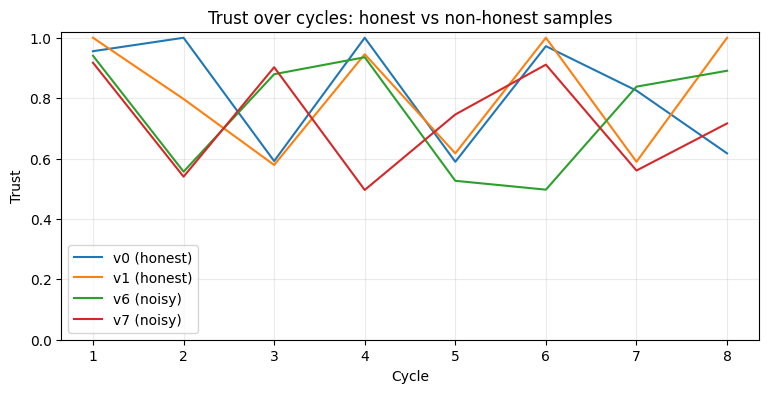

In [26]:
import matplotlib.pyplot as plt

def plot_trust_trajectories(trust_hist, vendor_types, chosen_ids, title="Trust trajectories"):
    x = np.arange(1, trust_hist.shape[0] + 1)
    plt.figure(figsize=(9,4))
    for vid in chosen_ids:
        plt.plot(x, trust_hist[:, vid], label=f"v{vid} ({vendor_types[vid]})")
    plt.ylim(0, 1.02)
    plt.xlabel("Cycle")
    plt.ylabel("Trust")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.show()

# choose a few
good_ids = np.where(vendor_types == "honest")[0][:2]
bad_ids  = np.where(vendor_types != "honest")[0][:2]
plot_trust_trajectories(trust_hist, vendor_types, list(good_ids) + list(bad_ids),
                        title="Trust over cycles: honest vs non-honest samples")


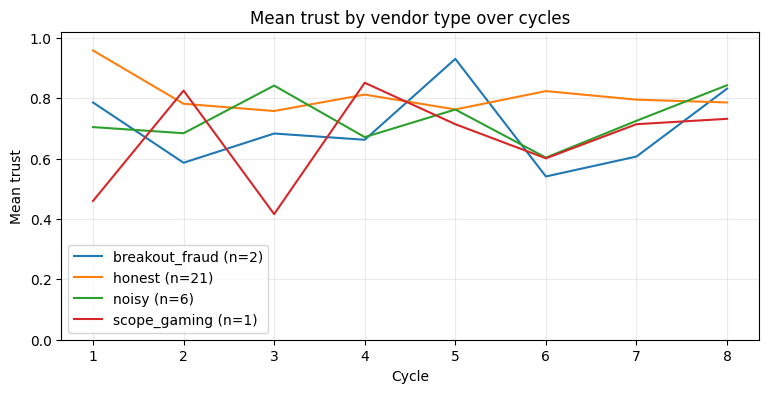

In [27]:
x = np.arange(1, trust_hist.shape[0] + 1)
plt.figure(figsize=(9,4))

for t in np.unique(vendor_types):
    idx = np.where(vendor_types == t)[0]
    mean_t = trust_hist[:, idx].mean(axis=1)
    plt.plot(x, mean_t, label=f"{t} (n={len(idx)})")

plt.ylim(0, 1.02)
plt.xlabel("Cycle")
plt.ylabel("Mean trust")
plt.title("Mean trust by vendor type over cycles")
plt.legend()
plt.grid(True, alpha=0.25)
plt.show()


In [28]:
hon = trust_final[vendor_types == "honest"]
non = trust_final[vendor_types != "honest"]
separation = hon.mean() - non.mean()
separation


np.float64(-0.042196966187086904)

In [29]:
def trust_metrics(trust_final, vendor_types, threshold=0.8):
    y_true = (vendor_types == "honest").astype(int)
    y_pred = (trust_final >= threshold).astype(int)

    tp = int(((y_true==1) & (y_pred==1)).sum())
    tn = int(((y_true==0) & (y_pred==0)).sum())
    fp = int(((y_true==0) & (y_pred==1)).sum())
    fn = int(((y_true==1) & (y_pred==0)).sum())

    prec = tp / (tp + fp + 1e-9)
    rec  = tp / (tp + fn + 1e-9)
    f1   = 2*prec*rec / (prec + rec + 1e-9)
    acc  = (tp + tn) / (tp + tn + fp + fn + 1e-9)

    return {"thr": threshold, "TP":tp, "TN":tn, "FP":fp, "FN":fn,
            "precision":prec, "recall":rec, "f1":f1, "accuracy":acc}

pd.DataFrame([trust_metrics(trust_final, vendor_types, thr) for thr in [0.6,0.7,0.8,0.9]])


,thr,TP,TN,FP,FN,precision,recall,f1,accuracy
0,0.6,18,0,9,3,0.666667,0.857143,0.750000,0.600000
1,0.7,15,0,9,6,0.625000,0.714286,0.666667,0.500000
2,0.8,9,4,5,12,0.642857,0.428571,0.514286,0.433333
3,0.9,5,7,2,16,0.714286,0.238095,0.357143,0.400000


In [32]:
GOOD_EVENTS = {"EvidenceAccepted", "RemediationAccepted"}
FAIL_EVENTS = {"EvidenceFreshnessFail", "EvidenceScopeFail", "EvidenceIncomplete", "EvidenceIntegrityFail"}

def utility_per_cycle(events_df, trust_vendors, num_vendors):
    # Good points: sum(rank) for accepted/remediation per vendor
    good = (events_df[events_df["event_type"].isin(GOOD_EVENTS)]
            .groupby("actor_id")["rank"].sum()
            .reindex(range(num_vendors), fill_value=0.0)
            .to_numpy())

    # Bad points: sum(bad_weight) for bad events per vendor
    bad = (events_df[events_df["is_bad"]]
           .groupby("actor_id")["bad_weight"].sum()
           .reindex(range(num_vendors), fill_value=0.0)
           .to_numpy())

    # Trust-weighted utility
    return float(np.sum(trust_vendors * (good - bad)))

# If you have per-cycle slices of events_df and per-cycle trust values:
# util[c] = utility_per_cycle(events_df.query("cycle == c"), trust_hist[c-1,:], num_vendors)
